# Comparison of aviation climate models

The purpose of this notebook is to compare various climate models (GWP*, FaIR, LWE) with each other and with reference data.

In [1]:
# Import libraries
import math
import numpy as np
import pandas as pd
import time
import copy
from pandas import read_csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from aerometrics.climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model
from aerometrics.climate_models.climate_models import aviation_climate_model

## Parameters

In [8]:
# "Historical": limit scope to historical emissions only.
# "Trend"
# "Stabilisation"
# "Halt"
scenario = "Historical"

In [9]:
# --- Emission scenario ---
commercial_aviation_historical_data_df = read_csv("../climate_data/aviation_emissions_data.csv", delimiter=";")
commercial_aviation_historical_data = commercial_aviation_historical_data_df.values

if scenario == "Historical":
    years_data = commercial_aviation_historical_data[:80, 0]
    co2_emissions_data = commercial_aviation_historical_data[:80, 1]
    nox_emissions_data = commercial_aviation_historical_data[:80, 2]
    h2o_emissions_data = commercial_aviation_historical_data[:80, 3]
    soot_emissions_data = commercial_aviation_historical_data[:80, 4]
    sulfur_emissions_data = commercial_aviation_historical_data[:80, 5]
    distance_data = commercial_aviation_historical_data[:80, 6]
    
else:
    years_data = commercial_aviation_historical_data[:, 0]
    co2_emissions_data = commercial_aviation_historical_data[:, 1]
    nox_emissions_data = commercial_aviation_historical_data[:, 2]
    h2o_emissions_data = commercial_aviation_historical_data[:, 3]
    soot_emissions_data = commercial_aviation_historical_data[:, 4]
    sulfur_emissions_data = commercial_aviation_historical_data[:, 5]
    distance_data = commercial_aviation_historical_data[:, 6]

start_year = int(years_data[0])
end_year = int(years_data[-1])
background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')

species_quantities = {
    'Aviation CO2': co2_emissions_data * 1e9, # [Mt to kg]
    'Aviation contrails': distance_data,
    'Aviation NOx - ST O3 increase': nox_emissions_data * 1e9,
    'Aviation NOx - CH4 decrease and induced': nox_emissions_data * 1e9,
    'Aviation H2O': h2o_emissions_data * 1e9,
    'Aviation soot': soot_emissions_data * 1e9,
    'Aviation sulfur': sulfur_emissions_data * 1e9,
}

if scenario == "Trend":
    pass
elif scenario == "Stabilisation":
    for key, val in species_quantities.items():
        for i in range(110, len(years_data)):
            species_quantities[key][i] = species_quantities[key][i-1] 
            
elif scenario == "Halt":
    for key, val in species_quantities.items():
        for i in range(110, len(years_data)):
            species_quantities[key][i] = 0.0

start_year = int(years_data[0])
end_year = int(years_data[-1])

In [10]:
# --- Climate settings ---
species_settings_gwpstar = {
    'Aviation CO2': {
        'sensitivity_rf': 0.0,
        'ratio_erf_rf': 1.0, 
        'efficacy_erf': 1.0
    }, 
    'Aviation contrails': {
        'sensitivity_rf': 2.23e-12,
        'ratio_erf_rf': 0.42, 
        'efficacy_erf': 1.0
    },  
    'Aviation NOx - ST O3 increase': {
        'sensitivity_rf': 25.1e-12 * (14/46),
        'ratio_erf_rf': 1.37, 
        'efficacy_erf': 1.0
    }, 
    'Aviation NOx - CH4 decrease and induced': {
        'sensitivity_rf': -26.1e-12 * (14/46) * 0.77,
        'ratio_erf_rf': 1.18, 
        'efficacy_erf': 1.0
    }, 
    'Aviation H2O': {
        'sensitivity_rf': 0.0052e-12,
        'ratio_erf_rf': 1.0, 
        'efficacy_erf': 1.0
    }, 
    'Aviation soot': {
        'sensitivity_rf': 100.7e-12,
        'ratio_erf_rf': 1.0, 
        'efficacy_erf': 1.0
    }, 
    'Aviation sulfur': {
        'sensitivity_rf': -19.9e-12,
        'ratio_erf_rf': 1.0, 
        'efficacy_erf': 1.0
    }, 
}

species_settings_others = copy.deepcopy(species_settings_gwpstar)
species_settings_others['Aviation NOx - CH4 decrease and induced']['sensitivity_rf'] = -3.90
tcre = 0.00045
model_settings_others = {"tcre": tcre}
model_settings_fair = {"background_species_quantities": background_species_quantities}

In [11]:
# --- Reference data for historical temperature change ---
reference_temperature_data_df = read_csv("../climate_data/reference_temperature_change_historic.csv", delimiter=";")
reference_temperature_data = reference_temperature_data_df.values
data_years = reference_temperature_data[:, 0]
data_temperature_grewe_curtech = np.full(len(years_data), np.nan)
data_temperature_grewe_curtech[:2019-1940+1] = reference_temperature_data[:, 1]
data_temperature_grewe_ecats = np.full(len(years_data), np.nan)
data_temperature_grewe_ecats[:2019-1940+1] = reference_temperature_data[:, 2]
data_temperature_klower = np.full(len(years_data), np.nan)
data_temperature_klower[:2019-1940+1] = reference_temperature_data[:, 3]
data_temperature_klower_co2 = np.full(len(years_data), np.nan)
data_temperature_klower_co2[:2019-1940+1] = reference_temperature_data[:, 4]

## Calculation

In [12]:
# --- Calculate temperature change obtained with each model (GWP*, LWE, FaIR) ---
time1 = time.time()
gwpstar_climate_model = aviation_climate_model(start_year, end_year, "GWP*", species_quantities, species_settings_gwpstar, model_settings_others)
time2 = time.time()
lwe_climate_model = aviation_climate_model(start_year, end_year, "LWE", species_quantities, species_settings_others, model_settings_others)
time3 = time.time()
fair_climate_model = aviation_climate_model(start_year, end_year, "FaIR", species_quantities, species_settings_others, model_settings_fair)
time4 = time.time()
fair2_climate_model = aviation_climate_model(start_year, end_year, species_fair_climate_model, species_quantities, species_settings_others, model_settings_fair)
time5 = time.time()
print("GWP*:", time2-time1, "s")
print("LWE:", time3-time2 ,"s")
print("FaIR:", time4-time3, "s")
print("FaIR (manual):", time5-time4, "s")

GWP*: 0.020355701446533203 s
LWE: 0.28341197967529297 s
FaIR: 0.4302561283111572 s
FaIR (manual): 0.7872540950775146 s


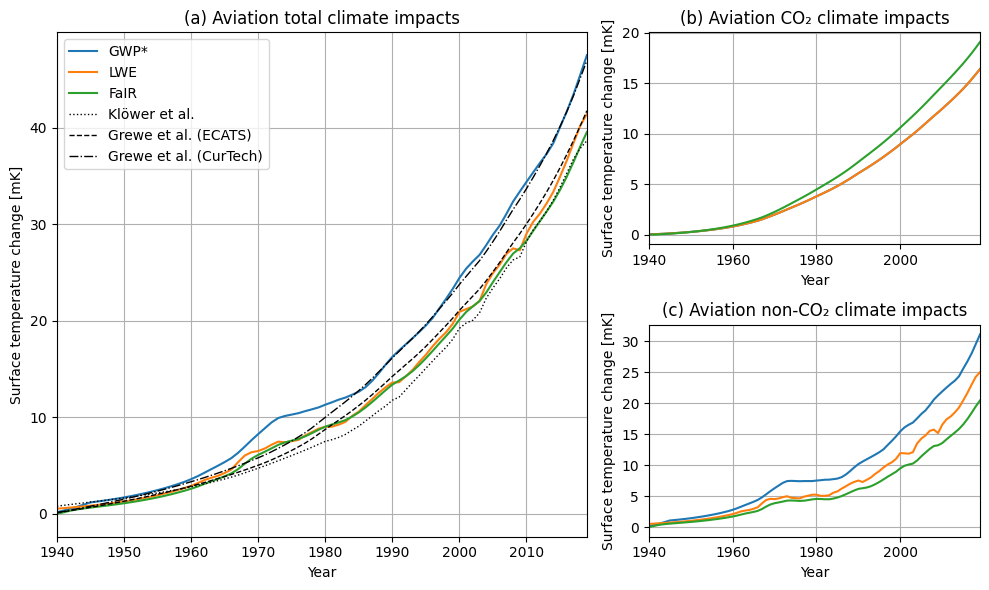

In [13]:
# --- Plot results ---
quantity = 'temperature increase'  # Select quantity to plot

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1.6, 1])

ax1 = fig.add_subplot(gs[:, 0])
ax1.plot(years_data, 1000 * gwpstar_climate_model['Aviation total'][quantity], label='GWP*')
ax1.plot(years_data, 1000 * lwe_climate_model['Aviation total'][quantity], label='LWE')
ax1.plot(years_data, 1000 * fair_climate_model['Aviation total'][quantity], label='FaIR')
ax1.plot(years_data, 1000 * data_temperature_klower/1000, label='Klöwer et al.', color='black', linestyle=":", linewidth=1)
ax1.plot(years_data, 1000 * data_temperature_grewe_ecats/1000, label='Grewe et al. (ECATS)', color='black', linestyle="--", linewidth=1)
ax1.plot(years_data, 1000 * data_temperature_grewe_curtech/1000, label='Grewe et al. (CurTech)', color='black', linestyle="-.", linewidth=1)
ax1.legend()
ax1.grid()
ax1.set_xlim(start_year, end_year)
ax1.set_xlabel('Year')
ax1.set_ylabel('Surface temperature change [mK]')
ax1.set_title("(a) Aviation total climate impacts")

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(years_data, 1000 * gwpstar_climate_model['Aviation CO2'][quantity], label='GWP*')
ax2.plot(years_data, 1000 * lwe_climate_model['Aviation CO2'][quantity], label='LWE')
ax2.plot(years_data, 1000 * fair_climate_model['Aviation CO2'][quantity], label='FaIR')
ax2.grid()
ax2.set_xlim(start_year, end_year)
ax2.set_xlabel('Year')
ax2.set_ylabel('Surface temperature change [mK]')
ax2.set_title('(b) Aviation CO₂ climate impacts')

ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(years_data, 1000 * gwpstar_climate_model['Aviation non-CO2'][quantity], label='GWP*')
ax3.plot(years_data, 1000 * lwe_climate_model['Aviation non-CO2'][quantity], label='LWE')
ax3.plot(years_data, 1000 * fair_climate_model['Aviation non-CO2'][quantity], label='FaIR')
ax3.grid()
ax3.set_xlim(start_year, end_year)
ax3.set_xlabel('Year')
ax3.set_ylabel('Surface temperature change [mK]')
ax3.set_title('(c) Aviation non-CO₂ climate impacts')

plt.tight_layout()
plt.savefig("figures/climate_model_comparison.pdf")
plt.show()